In [1]:
!pip install --upgrade pip
!pip install tensorflow

^C
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python3/bin/pip", line 11, in <module>
    sys.exit(main())
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pip/_internal/cli/main.py", line 73, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pip/_internal/commands/__init__.py", line 96, in create_command
    module = importlib.import_module(module_path)
  File "/home/ec2-user/anaconda3/envs/python3/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._b

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy import stats

import tensorflow as tf
keras = tf.keras


ModuleNotFoundError: No module named 'tf'

In [3]:
caiso = pd.read_csv('data/caiso_master.csv')
caiso.drop('Unnamed: 0', axis=1, inplace=True)
caiso['INTERVAL_START_PT'] = pd.to_datetime(caiso['INTERVAL_START_PT']).apply(lambda x: x.replace(tzinfo=None))
caiso['INTERVAL_END_PT'] = pd.to_datetime(caiso['INTERVAL_END_PT']).apply(lambda x: x.replace(tzinfo=None))
caiso['date_hour_start'] = pd.to_datetime(caiso['date_hour_start']).apply(lambda x: x.replace(tzinfo=None))
caiso['OPR_DT_PT'] = pd.to_datetime(caiso['OPR_DT_PT'])#.apply(lambda x: x.replace(tzinfo=None))

caiso.set_index('INTERVAL_START_PT', inplace=True)

caiso.rename({'HH_$_million_BTU_not_seasonal_adj': 'HH_$_mill_BTU'},axis=1, inplace=True)
caiso['HH_$_mill_BTU'] = pd.to_numeric(caiso['HH_$_mill_BTU'])

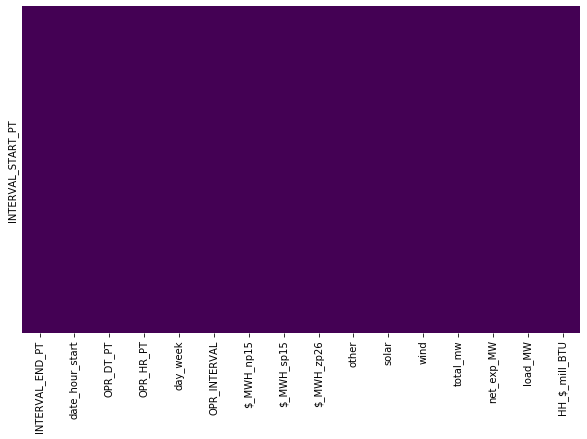

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(caiso.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [7]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out-1
        # Ensure that we do not 
        if out_end_idx > len(sequences):
            break
        seq_x, seq_y = sequences[i: end_idx, :-1], sequences[end_idx-1:out_end_idx, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

---
# LSTM

In [11]:
caiso.columns

Index(['INTERVAL_END_PT', 'date_hour_start', 'OPR_DT_PT', 'OPR_HR_PT',
       'day_week', 'OPR_INTERVAL', '$_MWH_np15', '$_MWH_sp15', '$_MWH_zp26',
       'other', 'solar', 'wind', 'total_mw', 'net_exp_MW', 'load_MW',
       'HH_$_mill_BTU'],
      dtype='object')

In [12]:
X_1 = caiso[['day_week', 'other', 'solar', 'wind', 'load_MW','HH_$_mill_BTU']]
y_np = caiso['$_MWH_np15']
y_sp = caiso['$_MWH_sp15']
y_zp = caiso['$_MWH_zp26']

In [14]:
X1_train, X1_test, y_np_train, y_np_test = train_test_split(X_1, y_np, test_size=0.2, random_state=42)

In [28]:
n_steps_in = X_train.shape[0]
n_features = X_train.shape[1]
n_steps_out = y_np_train.shape[0]

lstm_model = keras.Sequential()
lstm_model.add(keras.layers.LSTM(8, input_shape=(n_steps_in, n_features), return_sequences=False))
lstm_model.add(keras.layers.Dense(n_steps_out, activation='relu'))
lstm_model.compile(optimizer='adam', loss='mse')

In [15]:
X1_train.shape, X1_test.shape, y_np_train.shape, y_np_test.shape 

((9215, 6), (2304, 6), (9215,), (2304,))

In [29]:
lstm_model.fit(X1_train, y_np_train, batch_size=32, epochs=10)

Epoch 1/10


ValueError: in user code:

    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_7 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 6]
